In [1]:
!pip install transformers datasets scikit-learn

In [2]:
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [3]:
!pip install --upgrade datasets huggingface_hub fsspec

In [4]:
from datasets import load_dataset

In [5]:
dataset = load_dataset("emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
def map_labels(example):
    if example['label'] in [0, 5]:
        example['label'] = 0
    elif example['label'] in [1, 2]:
        example['label'] = 1
    else:
        example['label'] = 2
    return example

dataset = dataset.map(map_labels)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Step,Training Loss
50,0.916200
100,0.519600
150,0.365500
200,0.268600
250,0.290700
300,0.192700
350,0.232300
400,0.184800
450,0.154500
500,0.195700


TrainOutput(global_step=3000, training_loss=0.11911711768309276, metrics={'train_runtime': 4307.5465, 'train_samples_per_second': 11.143, 'train_steps_per_second': 0.696, 'total_flos': 1.2629444050944e+16, 'train_loss': 0.11911711768309276, 'epoch': 3.0})

In [15]:
from transformers import TextClassificationPipeline

In [16]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [31]:
texts = [
    "I dont want to live any more",
    "Life feels really difficult right now.",
    "Nothing special is happening."
]

In [32]:
for text in texts:
    result = pipeline(text)[0]
    label = result['label']
    if label == 'LABEL_0':
        emotion = 'Sad'
    elif label == 'LABEL_1':
        emotion = 'Happy'
    else:
        emotion = 'Neutral'
    print(f"Text: {text} → Emotion: {emotion}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Text: I dont want to live any more → Emotion: Happy
Text: Life feels really difficult right now. → Emotion: Sad
Text: Nothing special is happening. → Emotion: Happy


In [19]:
import shutil
import os
from google.colab import files
output_dir = "./results"
zip_filename = "model.zip"
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', output_dir)
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!git config --global user.email "23d101@psgitech.ac.in"
!git config --global user.name "rahularulbalan-011105"

In [21]:
!git clone https://github.com/rahularulbalan-011105/Naan-Mudhalvan.git


Cloning into 'Naan-Mudhalvan'...


In [35]:
!pip install evaluate
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [37]:
import evaluate


In [38]:
test_dataset = tokenized_datasets["test"]

In [39]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

In [40]:
target_names = ['sad', 'happy', 'neutral']
print("Classification Report:")
print(classification_report(labels, preds, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

         sad       0.96      0.95      0.95       647
       happy       0.99      0.99      0.99       854
     neutral       0.94      0.96      0.95       499

    accuracy                           0.97      2000
   macro avg       0.96      0.97      0.96      2000
weighted avg       0.97      0.97      0.97      2000



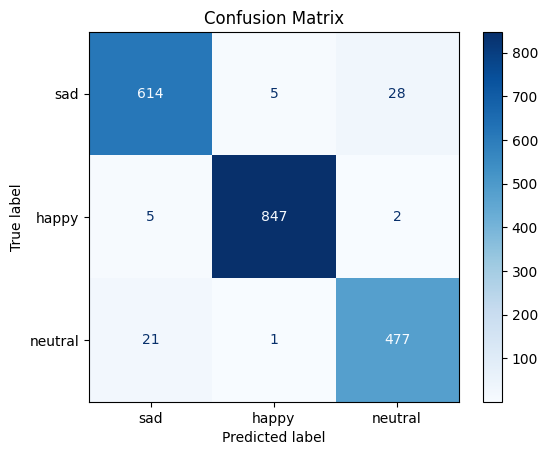

In [41]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [42]:
accuracy = np.mean(preds == labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.90%
